# Property appraisal ML project.
## Phase 2: adding NLP analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [2]:
# just reading the first sheet
df1 = pd.read_csv("0. F20 P1-Table 1.csv", na_values=['nan'])

# deleting yellow columns
df1.drop(['Status', 'For Tax Year', 'Gross Taxes', 'Original Price', 'List Price', 'GST Incl'], axis = 1, inplace = True)

# size of our dataset
print('Our dataset has', len(df1), 'data lines and', len(df1.columns.tolist()), 'features:')
print('\n')
print(df1.columns.tolist())

Our dataset has 558 data lines and 27 features:


['Address', 'distance', 'acessibility', 'S/A', 'Price', 'Sold Date', 'Days On Market', 'Age', 'Area', 'Total Bedrooms', 'Total Baths', 'Lot Sz (Sq.Ft.)', 'Floor Area -Grand Total', 'Driveway Finish', 'Floor Area - Unfinished', 'Foundation', 'Floor Area Fin - Basement', 'Zoning', 'Parking Places - Covered', '# Rms', 'No. Floor Levels', 'Frontage - Feet', 'Depth', 'Type', 'Unnamed: 30', 'Unnamed: 31', 'Public Remarks']


In [3]:
# dropping the columns with more than 90% NAs
moreThan = []

for feature in df1:
    if df1[feature].isna().sum() / df1.shape[0] > 0.9:
        moreThan.append(feature)
        print("Dropping the feature:", feature)
df1.drop(moreThan, axis = 1, inplace = True)

print('\n')

# dropping the columns that are not insightful: Days On Market, Public Remarks
# df1.drop(['Sold Date', 'Public Remarks'], axis=1, inplace = True)
df1.drop(['Sold Date'], axis=1, inplace = True)

columns_names = df1.columns.tolist()

print("Features left:")
print(columns_names)
print('\n')
print("Now we have", len(columns_names), "features and their types:")

# types of our columns
pd.DataFrame(df1.dtypes, columns=['DataTypes'])

Dropping the feature: distance
Dropping the feature: acessibility
Dropping the feature: Unnamed: 30
Dropping the feature: Unnamed: 31


Features left:
['Address', 'S/A', 'Price', 'Days On Market', 'Age', 'Area', 'Total Bedrooms', 'Total Baths', 'Lot Sz (Sq.Ft.)', 'Floor Area -Grand Total', 'Driveway Finish', 'Floor Area - Unfinished', 'Foundation', 'Floor Area Fin - Basement', 'Zoning', 'Parking Places - Covered', '# Rms', 'No. Floor Levels', 'Frontage - Feet', 'Depth', 'Type', 'Public Remarks']


Now we have 22 features and their types:


,DataTypes
Address,object
S/A,object
Price,object
Days On Market,int64
Age,int64
Area,object
Total Bedrooms,int64
Total Baths,int64
Lot Sz (Sq.Ft.),object
Floor Area -Grand Total,object


In [4]:
# the data is not cleaned!!! so we have to do something with that. 
# some features like Depth contain expressions like "99X44X32"

# a bit of cleanup

# in Address we need to take only the name of avenue 
df1['Address'] = df1['Address'].str.split(" ", 1).str[-1] 

# S/A nothing to do

# Price: remove $ and ,
df1['Price'] = df1['Price'].str.replace('$','')
df1['Price'] = df1['Price'].str.replace(',','')
df1['Price'] = df1['Price'].astype(float)
y = df1['Price']
# df1 = df1.drop(['Price'], axis=1)

# Days On Market nothing to do

# Age: delete outliers
df1['Age'][df1['Age'] > 100] == 0 ### or -1

# Area, Total Bedrooms, Total Baths: nothing to do

# Lot Sz (Sq.Ft.): remove , and .00
df1['Lot Sz (Sq.Ft.)'] = df1['Lot Sz (Sq.Ft.)'].str.replace(',', '')
df1['Lot Sz (Sq.Ft.)'] = df1['Lot Sz (Sq.Ft.)'].str.replace('.00', '')
df1['Lot Sz (Sq.Ft.)'] = df1['Lot Sz (Sq.Ft.)'].astype(float)

# Floor Area -Grand Total: remove ,
df1['Floor Area -Grand Total'] = df1['Floor Area -Grand Total'].str.replace(',', '')
df1['Floor Area -Grand Total'] = df1['Floor Area -Grand Total'].astype(float)

# Driveway Finish: replace nan's with Unknowns
df1['Driveway Finish'] = df1['Floor Area -Grand Total'].fillna('Unknown')

# Floor Area -Grand Total: remove ,
df1['Floor Area - Unfinished'] = df1['Floor Area - Unfinished'].str.replace(',', '')
df1['Floor Area - Unfinished'] = df1['Floor Area - Unfinished'].astype(float)

# Foundation: nothing to do

# Floor Area Fin - Basement: remove ,
df1['Floor Area Fin - Basement'] = df1['Floor Area Fin - Basement'].str.replace(',', '')
df1['Floor Area Fin - Basement'] = df1['Floor Area Fin - Basement'].astype(float)

# Zoning: maybe take a loot on intersection of two columns?!
df1['Zoning'] = df1['Zoning'].str.replace('1ACRER', 'RA')
df1['Zoning'] = df1['Zoning'].str.replace('1 AR', 'RA')
df1['Zoning'] = df1['Zoning'].str.replace('A1', 'A-1')
df1['Zoning'] = df1['Zoning'].str.replace('A2', 'A-2')
df1['Zoning'] = df1['Zoning'].str.replace('RF13', 'RF-13')
df1['Zoning'] = df1['Zoning'].str.replace('RHG', 'RH-G')
df1['Zoning'] = df1['Zoning'].str.replace('RS-1', 'RS1')
df1['Zoning'] = df1['Zoning'].str.replace('SING/F', 'SING')

# Parking Places - Covered: change nan's with 0 or -1
df1['Parking Places - Covered'] = df1['Parking Places - Covered'].fillna(0) ### or -1

# # Rms, No. Floor Levels: nothing to do

# Frontage - Feet: remove , and change nan with 0 oe -1
df1['Frontage - Feet'] = df1['Frontage - Feet'].str.replace(',', '')
df1['Frontage - Feet'] = df1['Frontage - Feet'].astype(float)
df1['Frontage - Feet'] = df1['Frontage - Feet'].fillna(0) ### or -1

# Depth: to work out!!!! now dropping
df1 = df1.drop(['Depth'], axis=1)

# Type: nothing to do 

# ooobj = df1['Depth']
# Counter(ooobj).keys()

In [5]:
# Below I do NLP processing on "Public Remarks" column using two techincs: 
# 1. Making a bag of words
# 2. using FastText wiki embeddings

In [6]:
# filling missing elements
nlp_column = df1["Public Remarks"].fillna('NaN')

# making standard tokenization process
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

nlp_column_punc_tokenized = [ preprocess(string) for string in nlp_column ]

from nltk.tokenize import word_tokenize
# nltk.download('punkt')

nlp_tokenized = ([word_tokenize(i) for i in nlp_column_punc_tokenized])

#then a bit of cleanup of tokenized elements
import itertools
from collections import Counter

tokenized_words_flatt = list(itertools.chain(*nlp_tokenized))
token_counts = Counter(tokenized_words_flatt)

# deleting words that occur less than 10 times
min_count = 10

from itertools import dropwhile
for key, count in dropwhile(lambda key_count: key_count[1] >= min_count, token_counts.most_common()):
    del token_counts[key]
    
tokens = token_counts.keys()

# add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Our Public Remarks column has", len(tokens), "different words.")

assert type(tokens) == list
assert UNK in tokens

# making a dictionary of words and their numbers
token_to_id = dict(zip(tokens, range(len(tokens))))

UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

# this function in fact transfers line of text into a matrix of numbers 
def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

print("\n")
print("Here is an example how the above NLP works. We take this line:")
print('\n'.join(nlp_column[::100000].values), end='\n\n')
print("And transfer it to matrix of numbers:", as_matrix(nlp_column[::100000]))


# finally, I do this 
X_nlp = as_matrix(nlp_tokenized, max_len=1000)

print("\n")
print("The overall shape of the NLPed matrix, i.e. we transfered one column of Public Remarks to a matrix of shape:")
np.shape(X_nlp)

Our Public Remarks column has 755 different words.


Here is an example how the above NLP works. We take this line:
Investor's alert. 3 bedroom tenanted home with lots of potential for holding and rebuilding. This home sits on 2 lots with a bright south facing front yard. Each lot is 2500 sqft and adds up to a total of 5000 sqft. The back yard is fenced and quiet. Perfect for holding and building 1 or 2 homes later. Enquire at the City about your building options. Location is very convenient: close to School, community centre and Scott Road skytrain station. Short drive to get to Patullo bridge and King George highway and South Perimeter road. Quiet home at the end of a no-thru road. Home is tenanted, please drive by first before scheduling a showing.

And transfer it to matrix of numbers: [[  0   0  32 105 658 345 739 415 473 530 283 344  69   0   0 345 605 480
   27 415 739  46 124 618 257 294   0   0 414 372   0 626  69   0 694 674
   46 680 473   0   0   0  88 747 372 267  69   0  

(558, 183)

In [7]:
### then we get back to the original baseline solution
# one-hot-encoding categorical features
X1 = pd.get_dummies(df1[['Address', 'S/A', 'Area', 'Foundation', 'Zoning', 'Type']])

# preprocessing the price feature
y = df1['Price']

# making polynomial transformation of numerical features
X2 = df1.drop(['Address', 'S/A', 'Area', 'Foundation', 'Zoning', 'Type', 'Price', 'Public Remarks'], axis = 1)
X2.fillna(0) ### or -1

poly = PolynomialFeatures(2)
X2_2 = poly.fit_transform(X2)

X2_3 = pd.DataFrame(X2_2, columns = poly.get_feature_names(X2.columns))
X2_3 = X2_3.drop(['1'], axis = 1)

X_nlp_df = pd.DataFrame(X_nlp)

# generating a big preprocessed dataset
X = pd.concat([X1, X2_3, X_nlp_df], axis = 1)

# rescaling it
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# norm = MinMaxScaler().fit(X)
norm = StandardScaler().fit(X)
X = pd.DataFrame(columns = X.columns, data = norm.transform(X))

# finally, we have 556 features (the case from baseline solution file has 373 features)
X.shape

(558, 556)

RMSE for linear regression: 26572.373568694333
RMSE for random forest regression: 68397.07523001879


weighted model: 0.8 * linear regressor + 0.19999999999999996 random forest regressor
RMSE for weighted regressor: 27389.49835234957


plotting scatter plots between predicted and actual prices to see if out model is good:


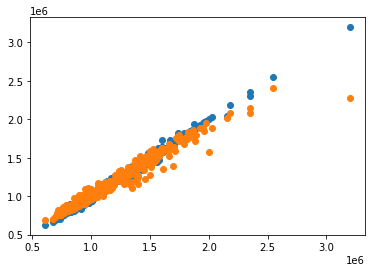

In [8]:
# let's make the same simple regressions on this

# calculate the logarithm of price
Y = np.log1p(y)


# LinearRegression model
lr = LinearRegression()
model_lr = lr.fit(X, Y)

predictions_lr = model_lr.predict(X)
print("RMSE for linear regression:", np.sqrt(mean_squared_error(y, np.expm1(predictions_lr))))

# RandomForest
rf = RandomForestRegressor(n_estimators=100)
model_rf = rf.fit(X, Y)

predictions_rf = model_rf.predict(X)
print("RMSE for random forest regression:", np.sqrt(mean_squared_error(y, np.expm1(predictions_rf))))


# let's take some weighted sum of these two regressions' predictions
weight_coeff = 0.8
predictions = (weight_coeff * predictions_lr + (1 - weight_coeff) * predictions_rf)
print('\n')
print("weighted model:", weight_coeff, "* linear regressor +", 1 - weight_coeff, "random forest regressor" )
print("RMSE for weighted regressor:", np.sqrt(mean_squared_error(y, np.expm1(predictions))))

# scatter plots
print('\n')
print("plotting scatter plots between predicted and actual prices to see if out model is good:")
plt.scatter(y, np.expm1(predictions_lr))
plt.scatter(y, np.expm1(predictions_rf))

In [9]:
# finally, let's check what we have
y_final = np.abs(np.expm1(predictions) - y)/(np.expm1(predictions)) * 100

final_matrix = [0, 0, 0, 0, 0]
for i in y_final:
    if i <= 2:
        final_matrix[0]+=1
    elif i <= 3:
        final_matrix[1]+=1
    elif i <= 5:
        final_matrix[2]+=1
    elif i <= 10:
        final_matrix[3]+=1
    else:
        final_matrix[4]+=1
        
for i in range(5):
    final_matrix[i] = np.round(final_matrix[i]/len(y_final) * 100, 1)
    
print("% of predictions accuracy: [<2%, 2 - 3%, 3 - 5%, 5 - 10%, >10%]")
print(final_matrix)
print('\n')
print("% of predictions, <=2% accuracy:", np.sum(final_matrix[:1]))
print("% of predictions, <=3% accuracy:", np.sum(final_matrix[:2]))
print("% of predictions, <=5% accuracy:", np.sum(final_matrix[:3]))
print("% of predictions, 5-10% accuracy:", np.sum(final_matrix[3]))
print("% of predictions,  >10% accuracy:", np.sum(final_matrix[4]))

% of predictions accuracy: [<2%, 2 - 3%, 3 - 5%, 5 - 10%, >10%]
[70.3, 15.1, 10.9, 3.6, 0.2]


% of predictions, <=2% accuracy: 70.3
% of predictions, <=3% accuracy: 85.39999999999999
% of predictions, <=5% accuracy: 96.3
% of predictions, 5-10% accuracy: 3.6
% of predictions,  >10% accuracy: 0.2


In [29]:
# recalling the output for baseline solution:

% of predictions accuracy: [<2%, 2 - 3%, 3 - 5%, 5 - 10%, >10%]
[51.4, 15.4, 17.6, 12.9, 2.7]


% of predictions, <=2% accuracy: 51.4
% of predictions, <=3% accuracy: 66.8
% of predictions, <=5% accuracy: 84.4
% of predictions, 5-10% accuracy: 12.9
% of predictions,  >10% accuracy: 2.7


==============



In [10]:
# now I do a better NLP using gensim fasttext embeddings for sentences.
# An advantage is this will give also the context of the words + will work better for unseen words

import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")
print("FASTTEXT is loaded.")

/Users/tigrani/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


FASTTEXT is loaded.


In [12]:
# using the same NOT PROCESSED Public Remarks 
# nlp_column

import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

nlp_column_punc_tokenized = [ preprocess(string) for string in nlp_column ]

from nltk.tokenize import word_tokenize

# here is my function that generates the word embeddings
def vectorize_sum(comment):
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    
    tokenized_comment = word_tokenize(comment)
    
    for word in tokenized_comment:
        if word in (embeddings.key_to_index):
            features += embeddings.get_vector(word)
        else: ## this is for the cases like '``'
            pass
    
    return features

X_fasttext_nlp = np.stack([vectorize_sum(text) for text in nlp_column_punc_tokenized])

print("Public Remarcks culomn is transformed to a matrix of form = ", np.shape(X_fasttext_nlp))

Public Remarcks culomn is transformed to a matrix of form =  (558, 300)


In [16]:
# adding this to the dataset
X_fasttext_df = pd.DataFrame(X_fasttext_nlp)
X = pd.concat([X1, X2_3, X_fasttext_df], axis = 1)

# rescaling it
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# norm = MinMaxScaler().fit(X)
norm = StandardScaler().fit(X)
X = pd.DataFrame(columns = X.columns, data = norm.transform(X))

# finally, we have 673 features (the case from baseline solution file has 373 features)
X.shape

(558, 673)

RMSE for linear regression: 2.0891571911920454e-08
RMSE for random forest regression: 72846.25160312455


weighted model: 0.8 * linear regressor + 0.19999999999999996 random forest regressor
RMSE for weighted regressor: 15697.800724189454


plotting scatter plots between predicted and actual prices to see if out model is good:


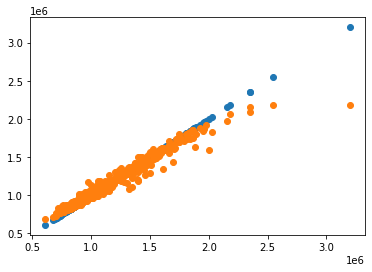

In [17]:
# let's make the same simple regressions on this

# calculate the logarithm of price
Y = np.log1p(y)


# LinearRegression model
lr = LinearRegression()
model_lr = lr.fit(X, Y)

predictions_lr = model_lr.predict(X)
print("RMSE for linear regression:", np.sqrt(mean_squared_error(y, np.expm1(predictions_lr))))

# RandomForest
rf = RandomForestRegressor(n_estimators=100)
model_rf = rf.fit(X, Y)

predictions_rf = model_rf.predict(X)
print("RMSE for random forest regression:", np.sqrt(mean_squared_error(y, np.expm1(predictions_rf))))


# let's take some weighted sum of these two regressions' predictions
weight_coeff = 0.8
predictions = (weight_coeff * predictions_lr + (1 - weight_coeff) * predictions_rf)
print('\n')
print("weighted model:", weight_coeff, "* linear regressor +", 1 - weight_coeff, "random forest regressor" )
print("RMSE for weighted regressor:", np.sqrt(mean_squared_error(y, np.expm1(predictions))))

# scatter plots
print('\n')
print("plotting scatter plots between predicted and actual prices to see if out model is good:")
plt.scatter(y, np.expm1(predictions_lr))
plt.scatter(y, np.expm1(predictions_rf))

In [18]:
# finally, let's check what we have
y_final = np.abs(np.expm1(predictions) - y)/(np.expm1(predictions)) * 100

final_matrix = [0, 0, 0, 0, 0]
for i in y_final:
    if i <= 2:
        final_matrix[0]+=1
    elif i <= 3:
        final_matrix[1]+=1
    elif i <= 5:
        final_matrix[2]+=1
    elif i <= 10:
        final_matrix[3]+=1
    else:
        final_matrix[4]+=1
        
for i in range(5):
    final_matrix[i] = np.round(final_matrix[i]/len(y_final) * 100, 1)
    
print("% of predictions accuracy: [<2%, 2 - 3%, 3 - 5%, 5 - 10%, >10%]")
print(final_matrix)
print('\n')
print("% of predictions, <=2% accuracy:", np.sum(final_matrix[:1]))
print("% of predictions, <=3% accuracy:", np.sum(final_matrix[:2]))
print("% of predictions, <=5% accuracy:", np.sum(final_matrix[:3]))
print("% of predictions, 5-10% accuracy:", np.sum(final_matrix[3]))
print("% of predictions,  >10% accuracy:", np.sum(final_matrix[4]))

% of predictions accuracy: [<2%, 2 - 3%, 3 - 5%, 5 - 10%, >10%]
[95.3, 2.5, 2.0, 0.2, 0.0]


% of predictions, <=2% accuracy: 95.3
% of predictions, <=3% accuracy: 97.8
% of predictions, <=5% accuracy: 99.8
% of predictions, 5-10% accuracy: 0.2
% of predictions,  >10% accuracy: 0.0


In [ ]:
# Insights from this step: now we have at least two NLP subalgorithms that are generating additional information.
# In fact the numbers above are showing almost nothing as the dataset initially is small and feeding it (having say 556 datapoints with 673 features)
# to any ML model will immidiately bring to overfitting. 

# However, these NLP technics will be used for the next step that is the similarity ranking algorithm: here I'll use my already developed one for similarity,
# add the NLP part and strenghten the algorithm with comments from John.